<a href="https://colab.research.google.com/github/MikhailDubovichev/Metallurgy-flotation-plant-optimization/blob/main/Mining_flotation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive summary:

I worked with a dataset, derived from the iron ore processing plant. The dataset contains around 6 months of observations, including ore input characteristics, readings of sensors, indicating technological process' (flotation) parameters, and quality of a final product - ore concentrate. The dataset contains 22 columns. The reading frequency varies from 1 to 180 mesures per hour.

The goal of the exercise was prediction of Silica (impurity of the ore concentrate) content in the final product based on input ore quality and processing characteristics, received from process sensors.

This project could be divided into 4 key parts:
1. Preliminary data analysis
2. Data preparation - creation of a dataframe, suitable for subsequent modeling
3. Modeling - Random forest regression
4. Modeling - Long-Short Term Memory (LSTM) model.

Both models showed low predictive power. The best R^2 on a testing set I was able to achieve is R^2=0.52, which might be explained by different reasons. My educated guess for the main reason for the low predictive power of the model (based on my knowledge of ore processing pain points) would be the low quality data on feed ore characteristics.

Of course, to make informed decisions about the data quality, predictive power of the model and means of improving it - it is necessary to discuss the technological process with operators.

My results are in line with other people who worked with this dataset and shared results. No one shared a model with high predictive power (exception - the guys who used "% iron concentrate" as an independent variable to predict "% silica concentrate"; this variable indeed has a strong predictive power, but we can use it in our model, because "% iron concentrate" and "% silica concentrate" are measured simultaneously).

# Preliminary data analysis (part 1)
The data I used here was downloaded from the Kaggle. Below is the description of the dataframe, from the person, who uploaded it to the Kaggle:


"This is a model based on Quality Prediction in a Mining Process data, I downloaded from Kaggle: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process/data

About Dataset
Context
It is not always easy to find databases from real world manufacturing plants, specially mining plants. So, I would like to share this database with the community, which comes from one of the most important parts of a mining process: a flotation plant!

The main goal is to use this data to predict how much impurity is in the ore concentrate. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions (empowering!). Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate).

Content
The first column shows time and date range (from march of 2017 until september of 2017). Some columns were sampled every 20 second. Others were sampled on a hourly base.

The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. From column 9 until column 22, we can see process data (level and air flow inside the flotation columns, which also impact in ore quality. The last two columns are the final iron ore pulp quality measurement from the lab.
Target is to predict the last column, which is the % of silica in the iron ore concentrate."

Mount of Google Drive

In [ ]:
# Here I mount the Google drive
# I could run this code separatelly at the beginnig of each session

from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


Import of the necessary libraries

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Preliminary raw data analysis (part 2)

Here we get some key data statistics and do some preliminary (mostly visual) analysis. The target is to understand how a data series looks and whether it has some unusual qualities - extra large peaks, data gaps, etc.

Analysis shows that our dataset has no missing data (not in any column).
At the same time, dataset has 1000+ duplicate rows, including 669 rows in one series, which corresponds to almost 4 hours of data (180 measures per hour for most of the sensors) - which looks like a problem with the data collection (ideally - it needs to be discuss with the person, who collected data). But, since we have only hourly data for the dependent variable (% Silica Concentrate), after generalization we will have only 3 identical data rows, so we could leave it as is.

Analysis also shows that our data series has a gap of 13+ days. Probably it is associated with the time when the flotation plant stood idle (it might be an annual repair).

         % Iron Feed  % Silica Feed    Starch Flow     Amina Flow  \
count  737453.000000  737453.000000  737453.000000  737453.000000   
mean       56.294739      14.651716    2869.140569     488.144697   
std         5.157744       6.807439    1215.203734      91.230534   
min        42.740000       1.310000       0.002026     241.669000   
25%        52.670000       8.940000    2076.320000     431.796000   
50%        56.080000      13.850000    3018.430000     504.393000   
75%        59.720000      19.600000    3727.730000     553.257000   
max        65.780000      33.400000    6300.230000     739.538000   

       Ore Pulp Flow    Ore Pulp pH  Ore Pulp Density  \
count  737453.000000  737453.000000     737453.000000   
mean      397.578372       9.767639          1.680380   
std         9.699785       0.387007          0.069249   
min       376.249000       8.753340          1.519820   
25%       394.264000       9.527360          1.647310   
50%       399.249000       9.798100 

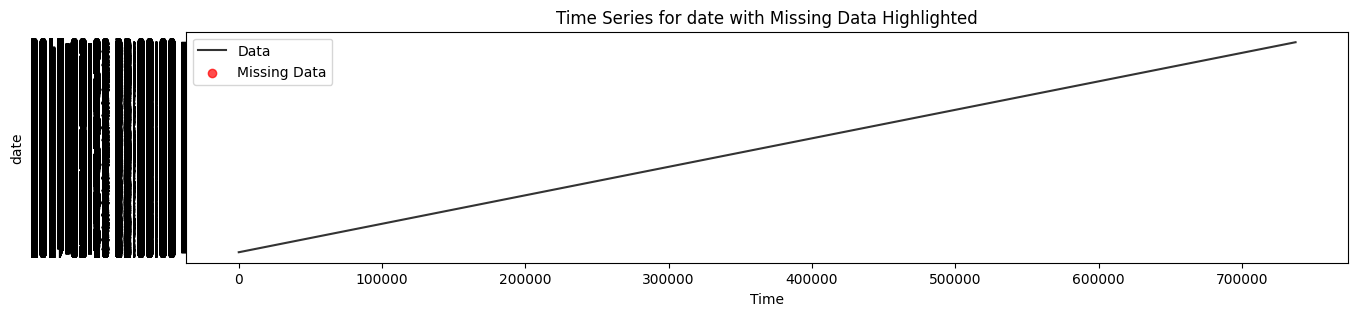

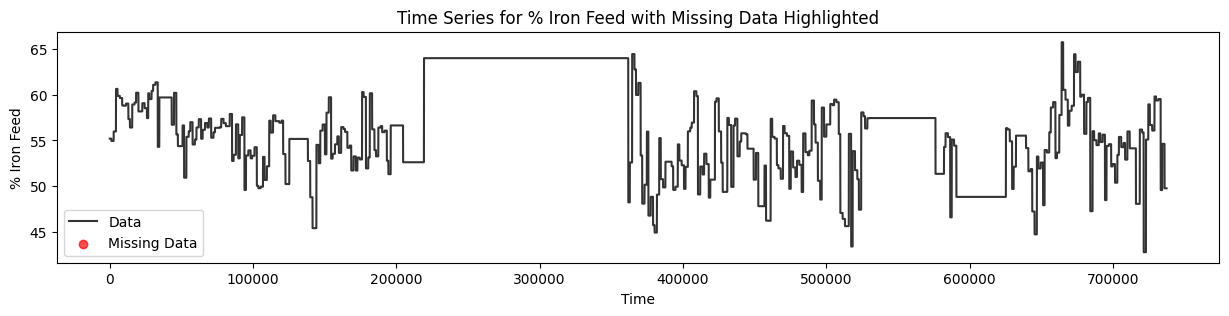

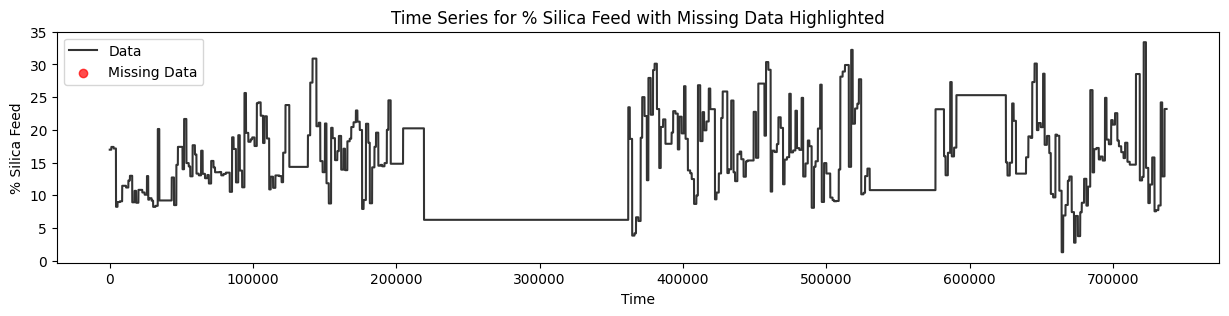

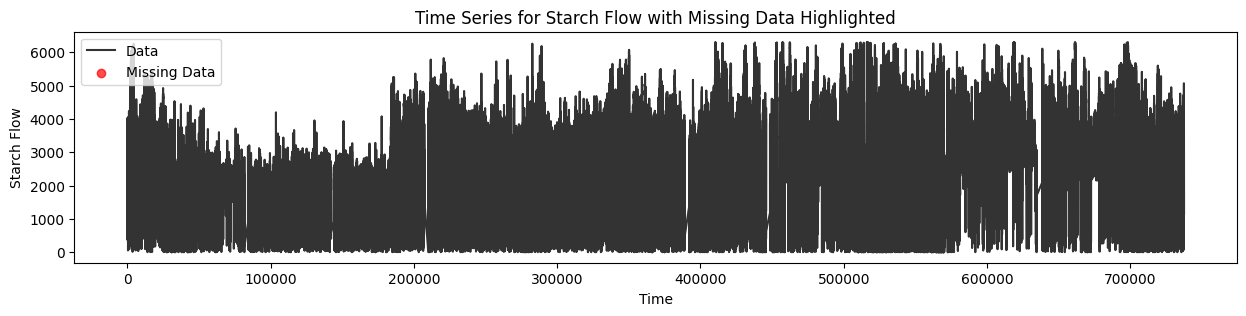

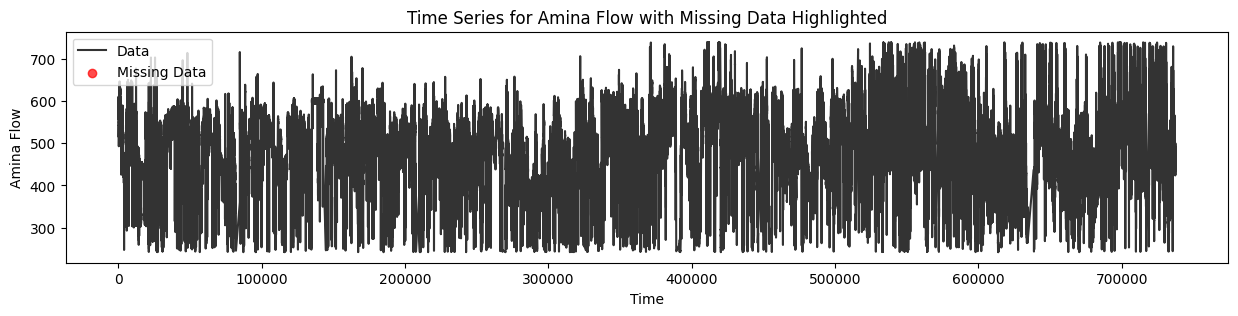

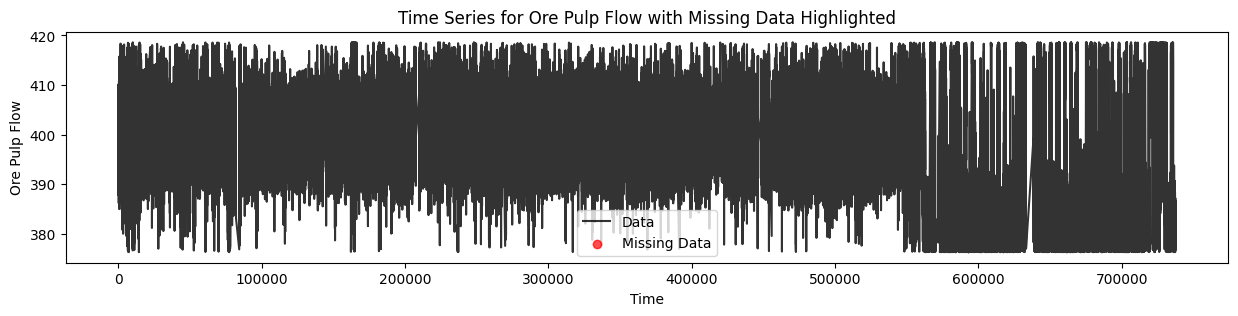

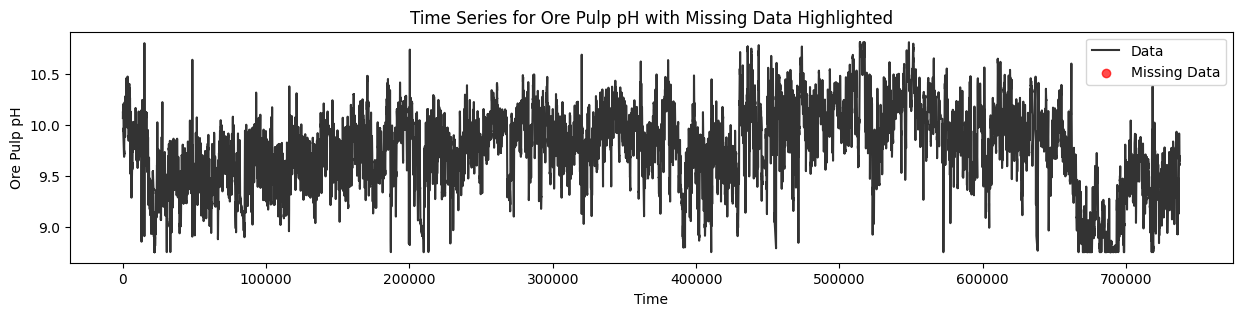

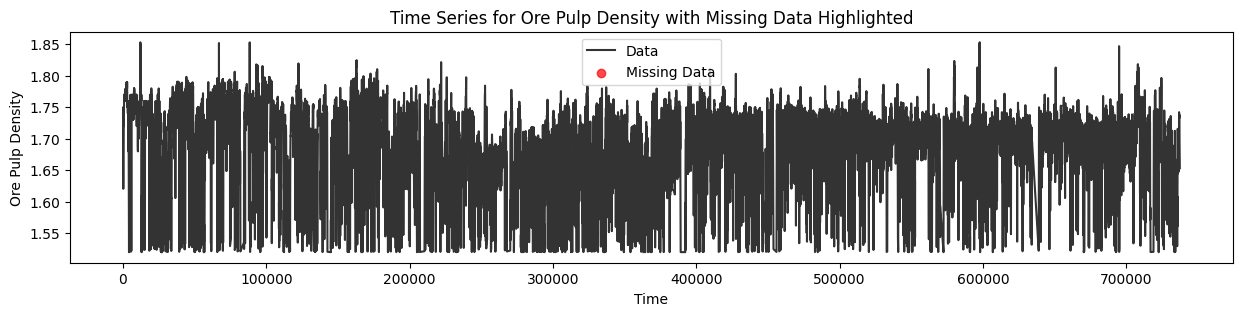

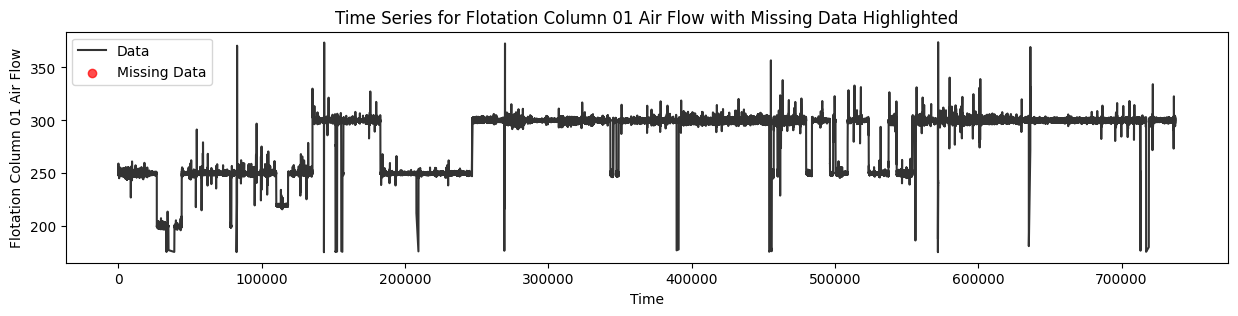

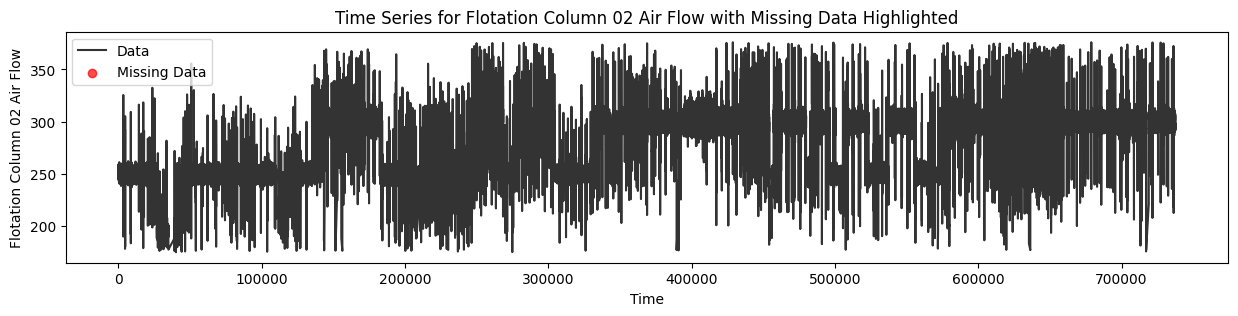

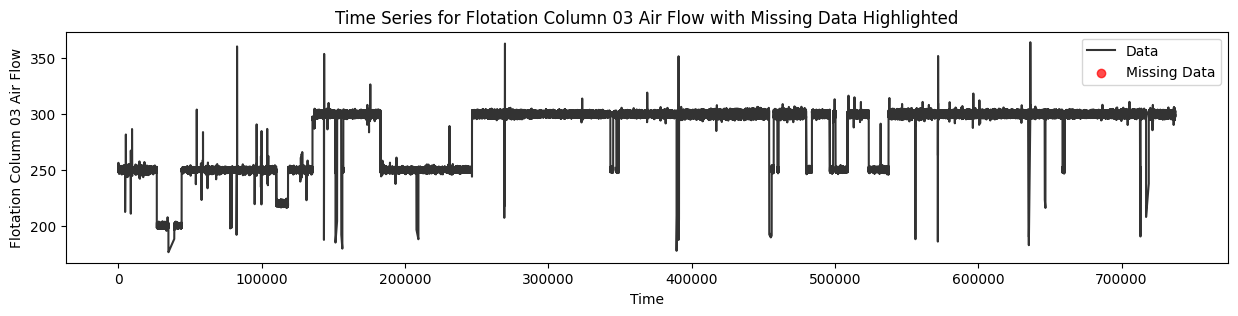

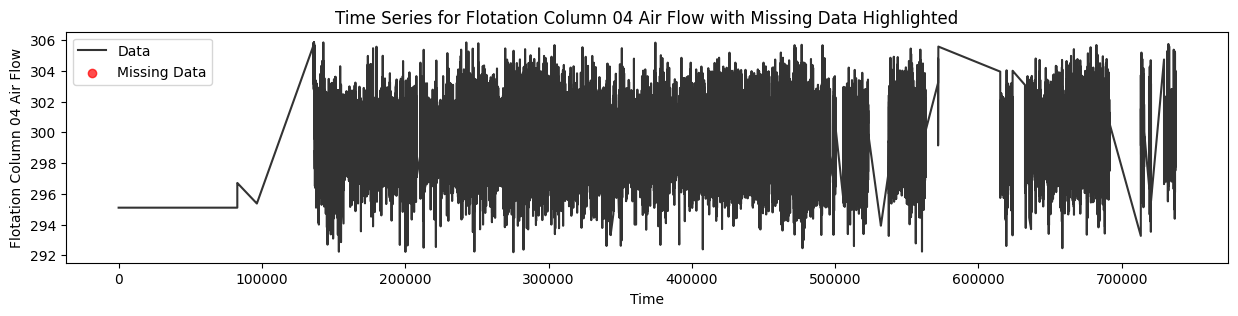

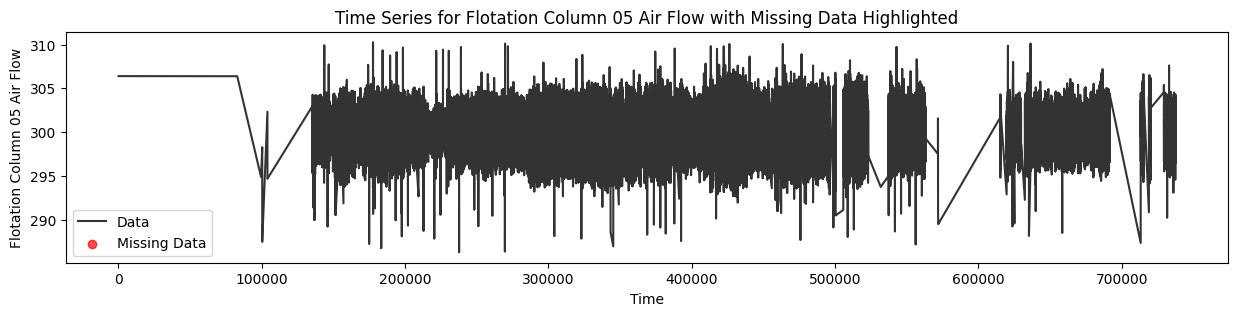

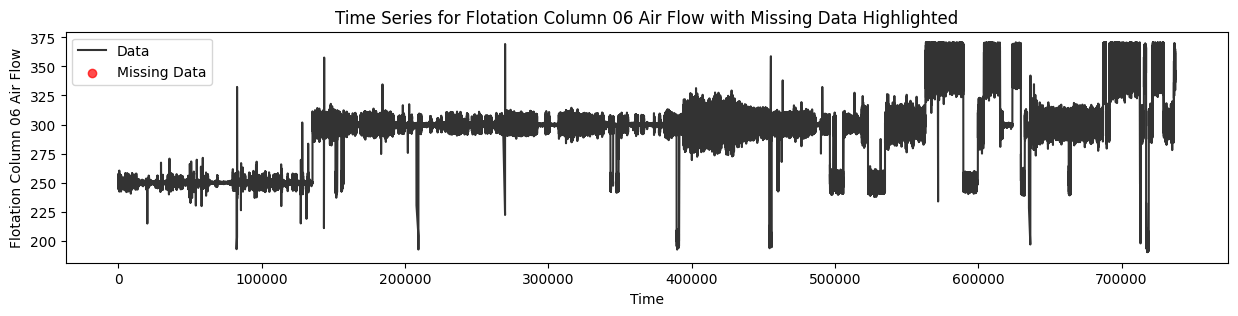

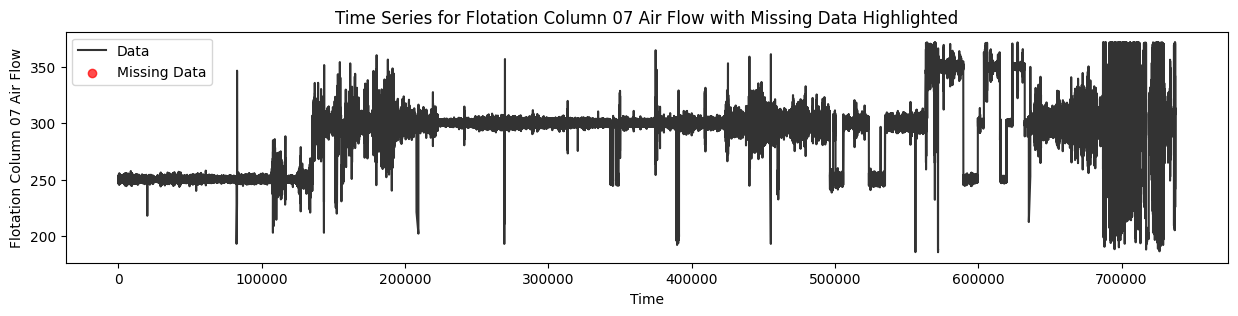

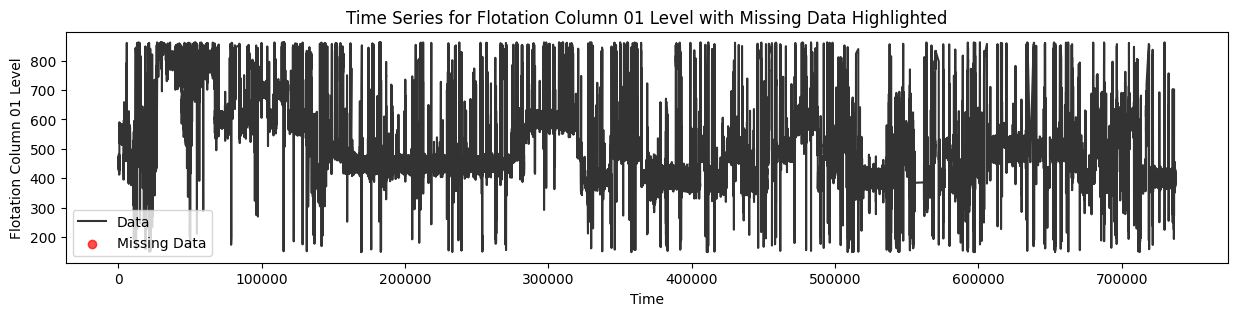

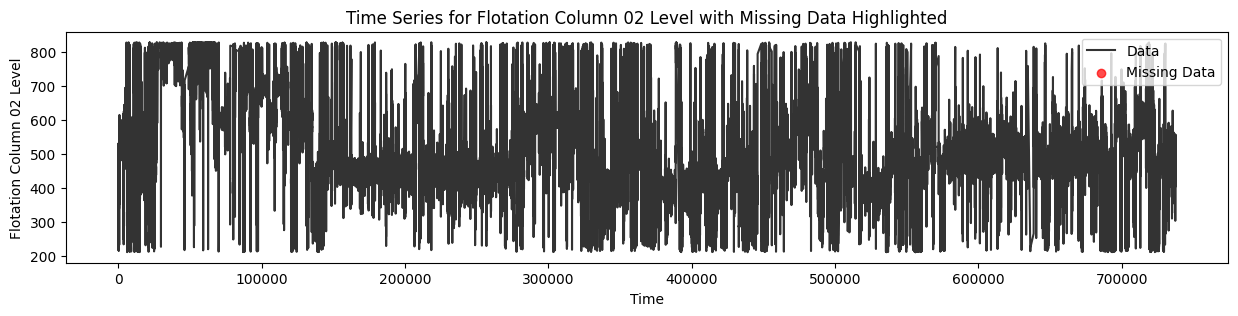

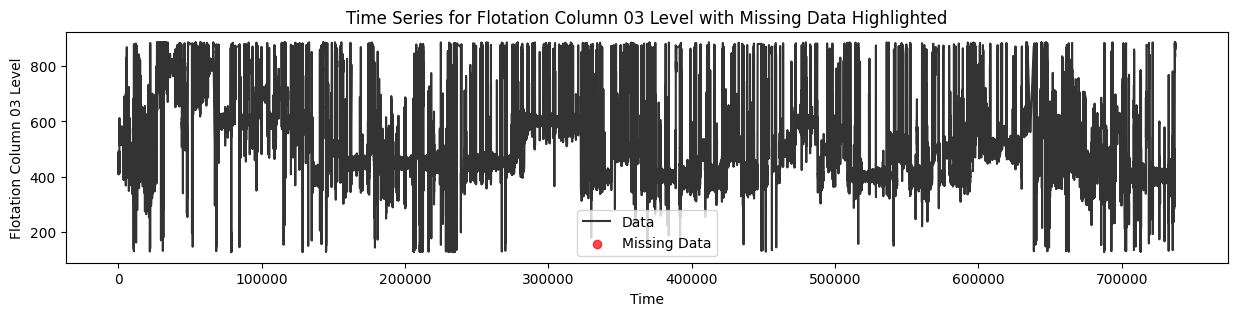

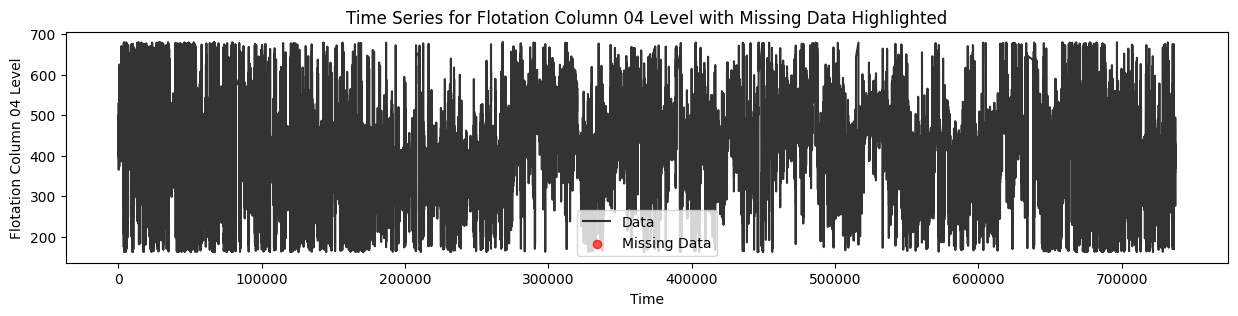

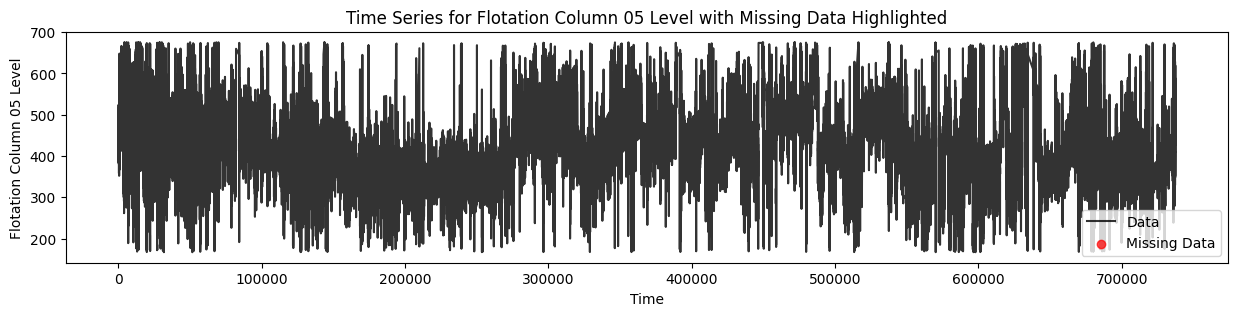

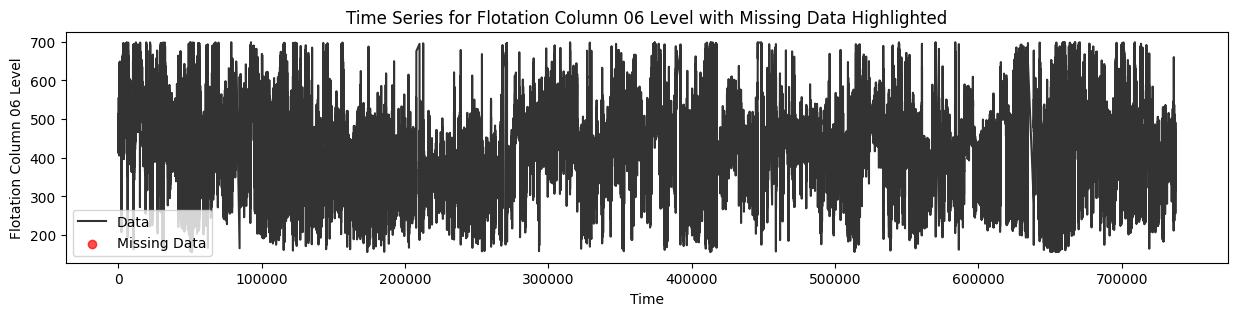

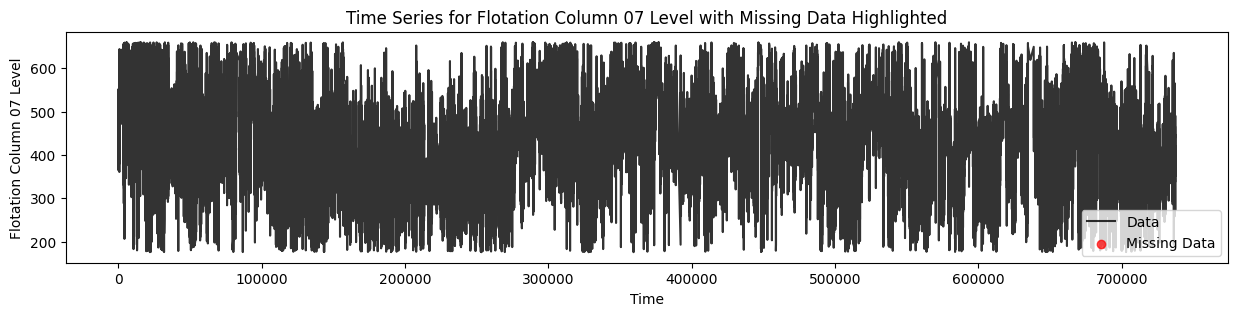

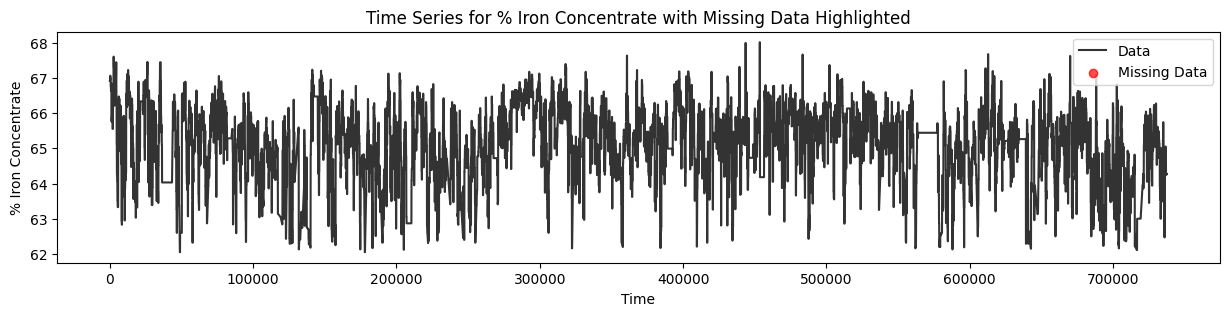

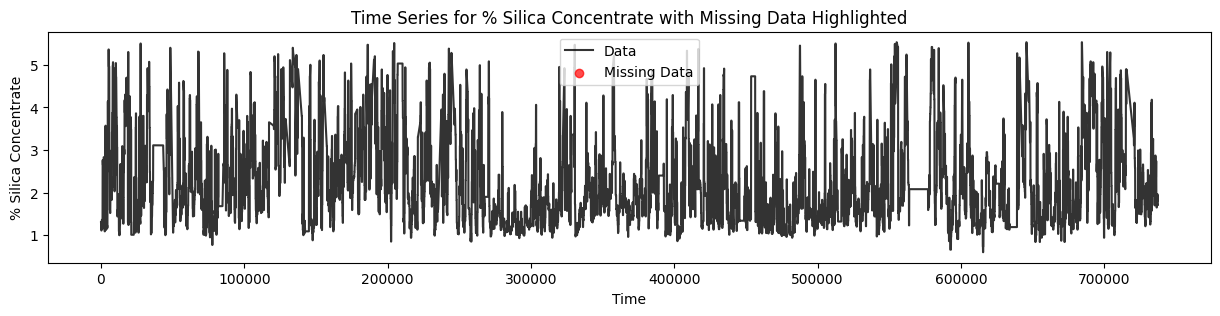

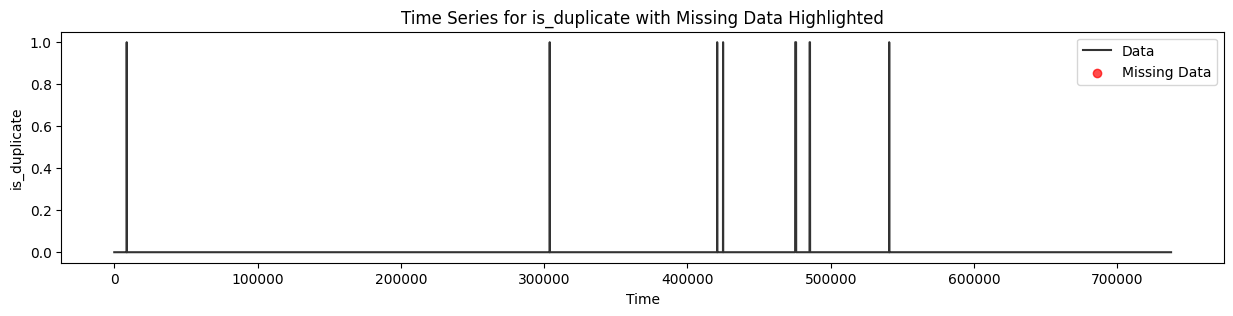

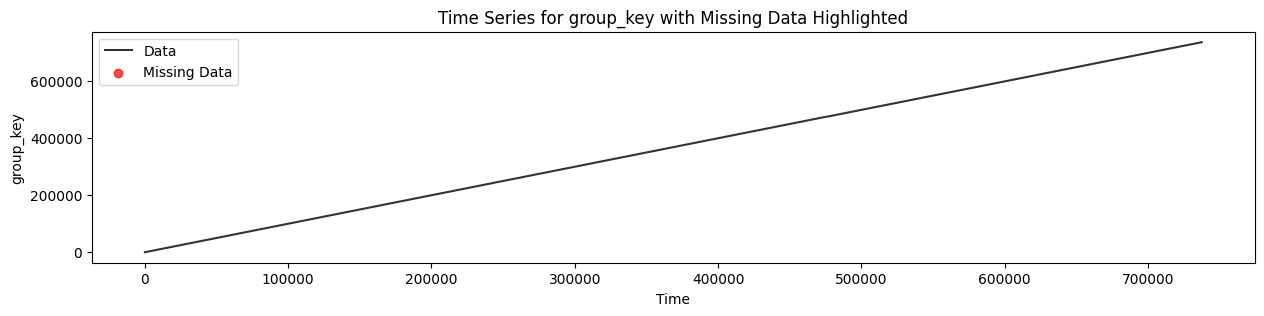

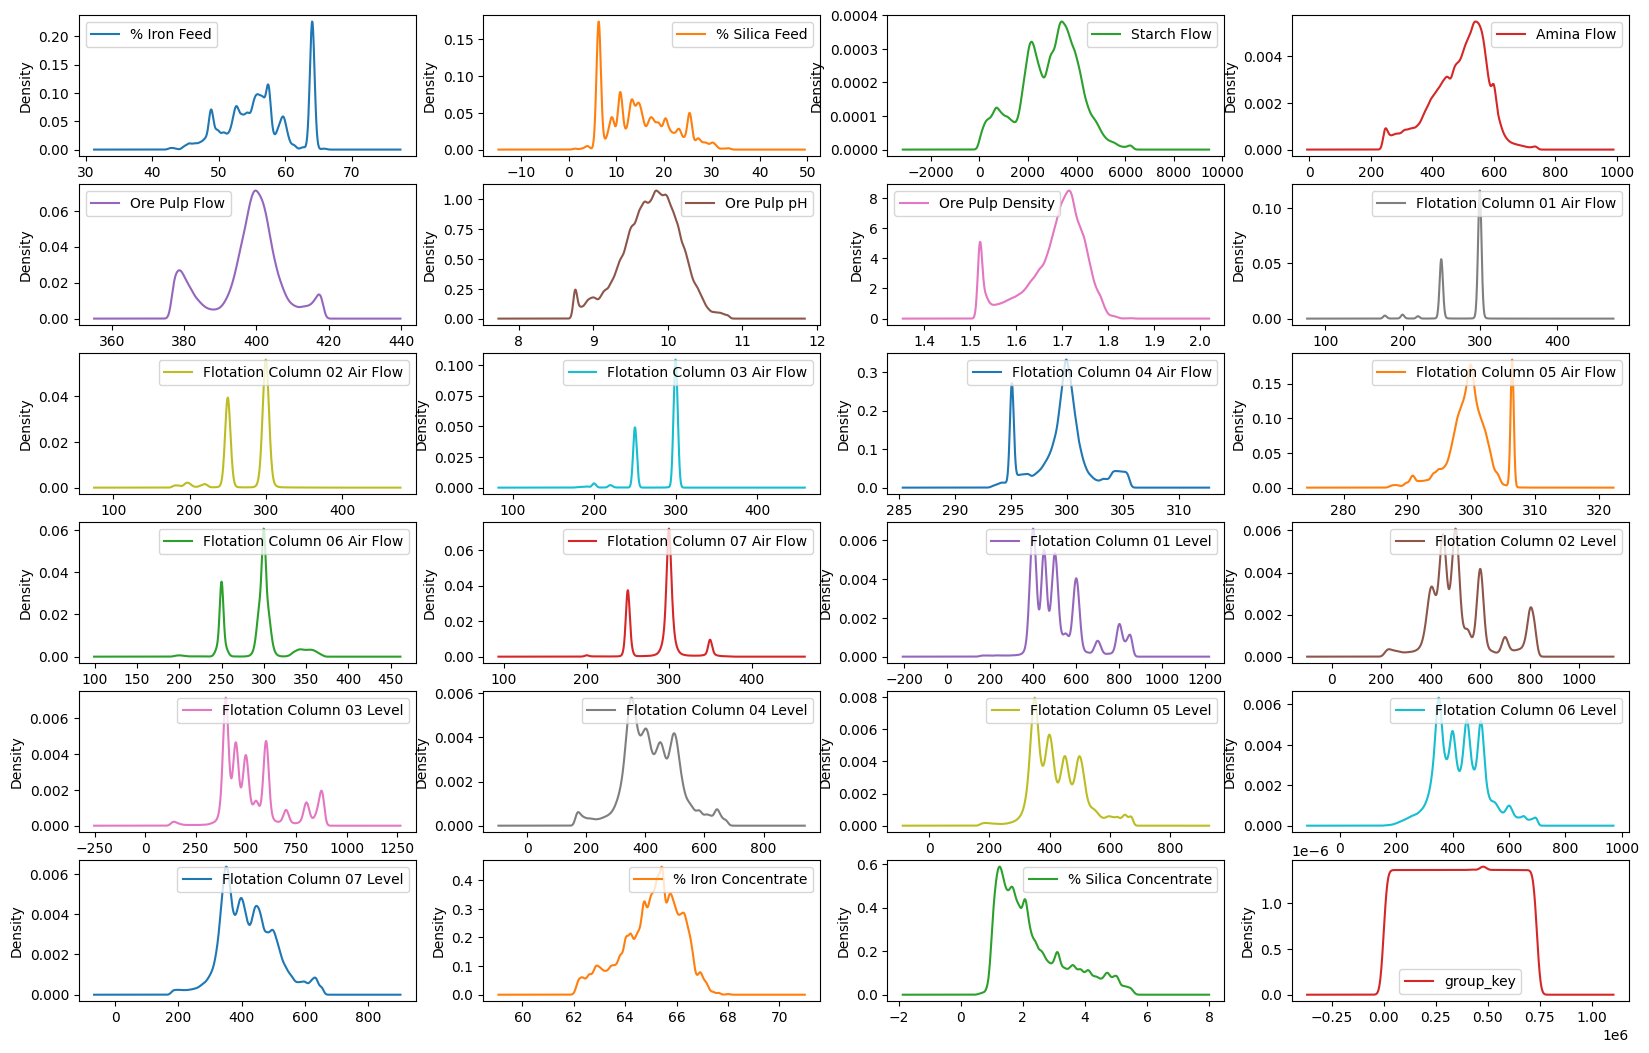

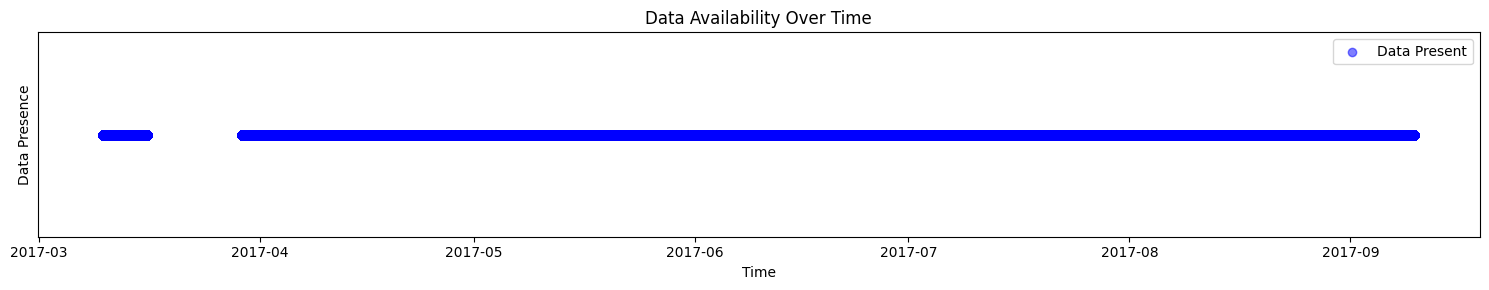

In [ ]:
# Load the dataset
# Note: The decimal=',' parameter is used because the data sample shows numbers using commas as decimal separators.
df = pd.read_csv('/content/gdrive/MyDrive/Colab_Files/Iron Ore Processing/MiningProcess_Flotation_Plant_Database.csv', decimal=',')

# Display the first few rows of the dataframe and key statistics
#print(df.head())
print (df.describe())

# Calculate missing data in the dataframe
initial_missing_data_counts = df.isnull().sum()
print()
print("Initial missing data counts per column:")
print(initial_missing_data_counts)

# Ensure there are no duplicate entries and that data is consistent across all features.
# This 5 lines of code check if there are duplicates in the dataset and count them.
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print()
print(f"Number of duplicate rows: {num_duplicates}")
print(df[duplicates])

# If there is a considerable amount of duplicating row - it is important to check how they are distributed.
# If it is a large number of short series of 3-5 duclications or we have one large duplicated series

# Step 1: Mark duplicates
df['is_duplicate'] = df.duplicated(keep=False)  # Mark all duplicates, including the first occurrence

# Step 2: Compute a grouping key
df['group_key'] = (~df['is_duplicate']).cumsum()

# Step 3: Group by the key and count duplicates only
duplicate_groups = df[df['is_duplicate']].groupby('group_key').size()

# Step 4: Find the maximum length of duplicate sequences
max_duplicate_length = duplicate_groups.max()

# Find the group key(s) with the maximum length
max_length_keys = duplicate_groups[duplicate_groups == max_duplicate_length].index

# Display the rows corresponding to the first occurrence of the maximum duplicate sequence
# If there are multiple sequences of the same maximum length, this will show the first one
max_duplicate_sequence = df[df['group_key'].isin(max_length_keys) & df['is_duplicate']]

print()
print(f"Maximum length of consecutive duplicate rows: {max_duplicate_length}")
print()
print("Maximum consecutive duplicate sequence:")
print(max_duplicate_sequence)


# Plot each column over time with missing data (if any) highlighted
for column in df.columns:
    plt.figure(figsize=(15, 3))
    plt.plot(df.index, df[column], 'k-', label='Data', alpha=0.8)
    # Highlight missing data points
    missing_points = df.index[df[column].isnull()]
    plt.scatter(missing_points, [df[column].min()] * len(missing_points), c='r', label='Missing Data', alpha=0.7)
    plt.title(f'Time Series for {column} with Missing Data Highlighted')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()


# Plot KDE (effectively, distribution density) for each numerical column
from math import ceil
df.plot(kind='density', subplots=True, layout=(ceil(len(df.columns) / 4), 4), sharex=False, figsize=(20,15))


# Parse dates and set index

# Ensure the 'date' column is parsed as datetime and set as the DataFrame's index
# This will facilitate resampling the data to hourly frequency and will allow to use all the timeseries functionality of Pandas library
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


# Here we do simple visualization to check if we have missing time periods in the dataframe
df['MissingMarker'] = 1  # Add a dummy column to mark presence of data
# Plotting
plt.figure(figsize=(15, 3))
# Scatter plot for actual data points
plt.scatter(df.index, df['MissingMarker'], c='blue', label='Data Present', alpha=0.5)

plt.title('Data Availability Over Time')
plt.xlabel('Time')
plt.ylabel('Data Presence')
plt.yticks([])  # Hide y-axis ticks as they are not meaningful in this context
plt.legend()
plt.tight_layout()

# This plot will show points for each timestamp where data is present. Missing periods won't have points.
plt.show()

#It looks like we have missed period of more than 13 days


#Data cleaning and preparation (part 1):

At the preliminary data analysis above we found out that the data series has a gap of 13+ days. Probably it is associated with the time when the flotation plant stood idle (it might be an annual repair).

To deal with the gap we divide time series in two subseries: before_gap and after_gap.

Vast majority of the data contained in the second part of the data. So, we would use only this second part of the data for our analysis. If results of that analysis wouldn't be satisfactory, we might think of adding somehow the before_gap part to the analysis

In [ ]:

# Reload the dataset
# I'm reloading the dataset because it might be alterred at the "Preliminary raw data analysis" during, for example, missing data calculation
df = pd.read_csv('/content/gdrive/MyDrive/Colab_Files/Iron Ore Processing/MiningProcess_Flotation_Plant_Database.csv', decimal=',')

# Convert 'date' column to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Drop the first incomplete hour if needed
start_time_of_second_hour = '2017-03-10 02:00:00'
df = df.loc[start_time_of_second_hour:]

# Calculate differences between consecutive timestamps
timestamp_diffs = df.index.to_series().diff()

# Identify the start of the largest gap
largest_gap_start = timestamp_diffs.idxmax()

# Find the index immediately after the largest gap start to get the actual end of the gap
gap_end_index = df.index[df.index > largest_gap_start].min()

# Segment the dataset into two parts, before and after the gap
df_before_gap = df.loc[:largest_gap_start]
df_after_gap = df.loc[gap_end_index:]

print(f"Start of the dataset: {df.index.min()}")
print(f"Start of the gap: {largest_gap_start}")
print(f"End of the gap (start of data after gap): {gap_end_index}")
print(f"End of the dataset: {df.index.max()}")

print(df_after_gap.head())



'''
# Check if there are Null data
#print(df.isnull().sum())
print("The number of null data before filling:", df.isnull().sum())

# Convert all columns to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

print("The number of null data after converting to numeric:", df.isnull().sum())

# Forward fill to impute missing values
df.fillna(method='ffill', inplace=True)

print("The number of null data after filling the missing data:", df.isnull().sum())

# Downsampling to Hourly Data

# For some sensors we have 20-second data, for others - hourly data, so we want to agregate all the data to hourly format
# Here we aggregate the 20-second interval data to hourly frequency using mean aggregation method.
# This downsampling step converts high-frequency data to a consistent hourly format, making it easier to analyze and model.
hourly_df = df.resample('H').mean()

# Check if there are Null data
#print(hourly_df.isnull().sum())
print("The number of null data after downsampling to hourly:", hourly_df.isnull().sum())

# Check for Duplicates and Consistency

# Ensure there are no duplicate entries and that data is consistent across all features.
# This 3 lines of code check if there are duplicates in the dataset and count them.
duplicates = hourly_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")
print(df[duplicates])

# Drop duplicated if necessery
# hourly_df = hourly_df.drop_duplicates()

# Final review: perform a final review of the prepared data to ensure it's ready for modeling
print(hourly_df.head())
print(hourly_df.describe())


# Use visualization tools to plot key features and verify data quality visually
# import matplotlib.pyplot as plt
#hourly_df[['% Silica Concentrate', '% Iron Concentrate']].plot(figsize=(15, 5))
#plt.show()
'''


Start of the dataset: 2017-03-10 02:00:00
Start of the gap: 2017-03-29 12:00:00
End of the gap (start of data after gap): 2017-03-29 13:00:00
End of the dataset: 2017-09-09 23:00:00
                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
date                                                                       
2017-03-29 13:00:00        60.18           9.34      2510.36     306.635   
2017-03-29 13:00:00        60.18           9.34      2449.08     304.276   
2017-03-29 13:00:00        60.18           9.34      2383.73     301.823   
2017-03-29 13:00:00        60.18           9.34      2295.37     299.681   
2017-03-29 13:00:00        60.18           9.34      2206.08     297.392   

                     Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
date                                                                
2017-03-29 13:00:00        402.303      9.63786          1.524512   
2017-03-29 13:00:00        402.132      9.64054          1.524477   
2017-03-2

'\n# Check if there are Null data\n#print(df.isnull().sum())\nprint("The number of null data before filling:", df.isnull().sum())\n\n# Convert all columns to numeric, coercing errors to NaN\ndf = df.apply(pd.to_numeric, errors=\'coerce\')\n\nprint("The number of null data after converting to numeric:", df.isnull().sum())\n\n# Forward fill to impute missing values\ndf.fillna(method=\'ffill\', inplace=True)\n\nprint("The number of null data after filling the missing data:", df.isnull().sum())\n\n# Downsampling to Hourly Data\n\n# For some sensors we have 20-second data, for others - hourly data, so we want to agregate all the data to hourly format\n# Here we aggregate the 20-second interval data to hourly frequency using mean aggregation method.\n# This downsampling step converts high-frequency data to a consistent hourly format, making it easier to analyze and model.\nhourly_df = df.resample(\'H\').mean()\n\n# Check if there are Null data\n#print(hourly_df.isnull().sum())\nprint("The nu

# Data cleaning and preparation (part 2):

In the first part of the data preparation we found out that our data series has a gap of around 13 days, which might be related to a period when our plant was idle. This gap divides our data set into two parts (before_the_gap, after_the_gap). It turned out that the after_the_gap set contains more than 95% of the data, so for practical purposes, starting from here we will work with the after_the_gap only. Below we prepare this data set for model training: we fill the gaps in the data, check for duplicate rows and, what is really important - resample the data from 20-second intervals to hourly ones.

Why do we downsize the data to an hourly-series? It might look like losing some important information, since the vast majority of our data is presented by 20-seconds data serieses. The key reason is that our dependent variable (% Silica Concentrate) - the variable we would like to predict - is presented in hourly intervals. So we can't "catch" variations of dependent variables inside each of the hourly intervals.

As the result of the code snippet below we get a downsamles dataframe ready for modeling.

         % Iron Feed  % Silica Feed    Starch Flow     Amina Flow  \
count  710459.000000  710459.000000  710459.000000  710459.000000   
mean       56.219298      14.769166    2847.466445     488.748398   
std         5.230777       6.887179    1215.686179      91.305798   
min        42.740000       1.310000       0.002026     241.669000   
25%        52.610000       8.790000    2060.550000     432.133500   
50%        55.940000      14.200000    2982.340000     504.742000   
75%        59.720000      20.140000    3711.120000     553.854000   
max        65.780000      33.400000    6300.230000     739.538000   

       Ore Pulp Flow    Ore Pulp pH  Ore Pulp Density  \
count  710459.000000  710459.000000     710459.000000   
mean      397.470523       9.769704          1.679075   
std         9.793062       0.387050          0.068762   
min       376.249000       8.753370          1.519820   
25%       394.065000       9.528880          1.646090   
50%       399.207000       9.798590 

<ipython-input-5-0b3dd37b5fd1>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[duplicates])


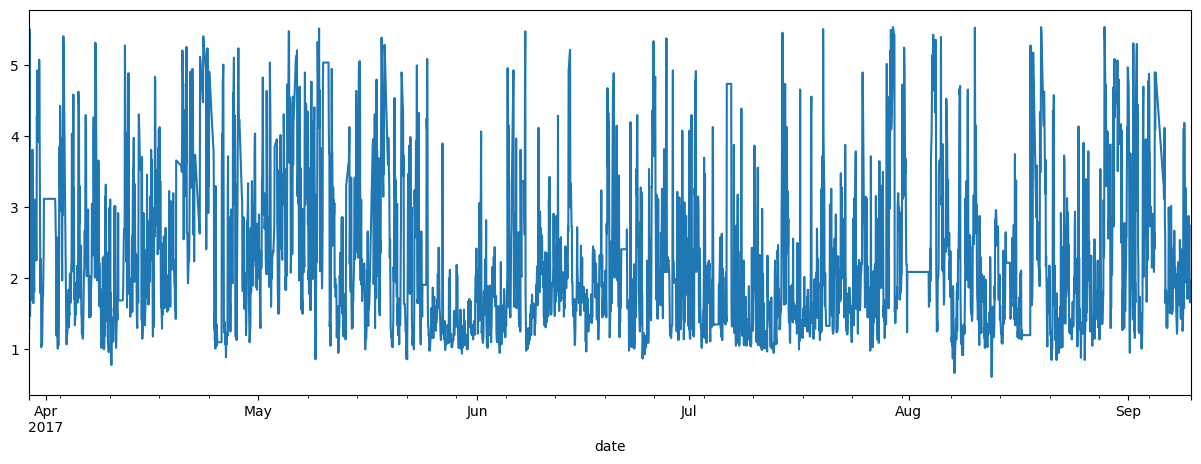

In [ ]:
df = df_after_gap

print(df.describe())

# Check if there are Null data
#print(df.isnull().sum())
print("The number of null data before filling:", df.isnull().sum())

# Convert all columns to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

print("The number of null data after converting to numeric:", df.isnull().sum())

# Forward fill to impute missing values
df.fillna(method='ffill', inplace=True)

print("The number of null data after filling the missing data:", df.isnull().sum())

# Downsampling to Hourly Data

# For some sensors we have 20-second data, for others - hourly data, so we want to agregate all the data to hourly format
# Here we aggregate the 20-second interval data to hourly frequency using mean aggregation method.
# This downsampling step converts high-frequency data to a consistent hourly format, making it easier to analyze and model.
hourly_df = df.resample('H').mean()

# Check if there are Null data
#print(hourly_df.isnull().sum())
print("The number of null data after downsampling to hourly:", hourly_df.isnull().sum())

# Check for Duplicates and Consistency

# Ensure there are no duplicate entries and that data is consistent across all features.
# This 3 lines of code check if there are duplicates in the dataset and count them.
duplicates = hourly_df.duplicated()
num_duplicates = duplicates.sum()
print()
print(f"Number of duplicate rows: {num_duplicates}")
print(df[duplicates])
print()

# Drop duplicated if necessery
# hourly_df = hourly_df.drop_duplicates()

# Final review: perform a final review of the prepared data to ensure it's ready for modeling
print(hourly_df.head())
print(hourly_df.describe())


# Use visualization tools to plot key features and verify data quality visually
import matplotlib.pyplot as plt
#hourly_df[['% Silica Concentrate', '% Iron Concentrate']].plot(figsize=(15, 5))
hourly_df['% Silica Concentrate'].plot(figsize=(15, 5))
plt.show()




# Modeling - Random Forest Regression (part 1):

Now when we got a fully prepared for modeling dataframe (hourly_df dataframe) we could actually make a first attempt of model fitting. We will try to fit a random forest model and get first results.

I actually run random forest regression twice.

First time I fit Random forest with all the variables. To fit a random forest model I used all the independent variables and got not remarkable but OK results - R^2 is 0.65. When I did an importance factor analysis, it turned out that % Iron Concentrate has huge importance - way higher than the one of any other variable. This makes perfect sense since % Iron and % Silica concentrates are highly negatively correlated.

The problem is that the % Iron Concentrate couldn't be used to predict % Silica Concentrate - they are measured simultaneously. So this column should definitely be dropped.

So, below we trained the Random forest with dropped column [% Iron Concentrate]. And this drop led to a drastic decrease of Testing R^2. It goes all the way down to 0.05. So, basically, after we dropped the column the model lost all its predictive power.

Besides fitting the model I also did Feature Importance Analysis and SHAP analysis to visualize importance of different variables.


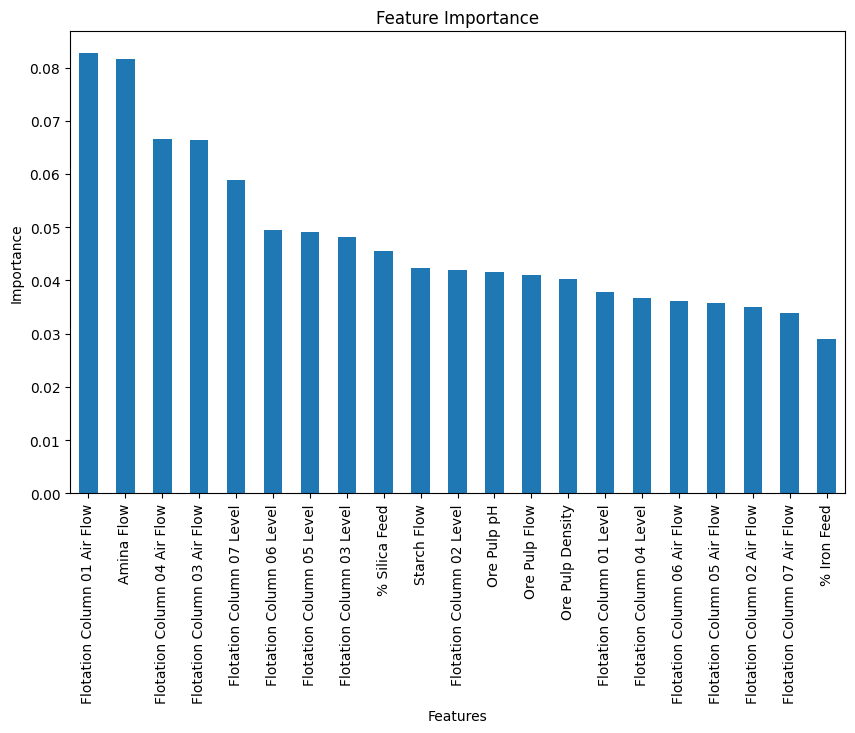



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.5 MB/s eta 0:00:00


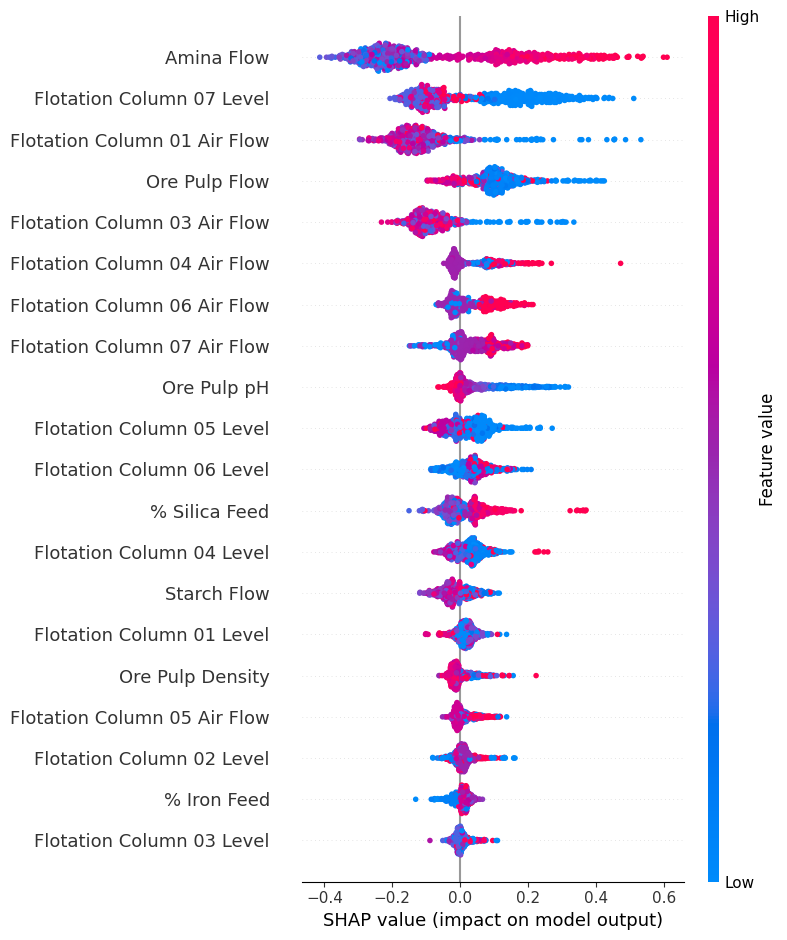

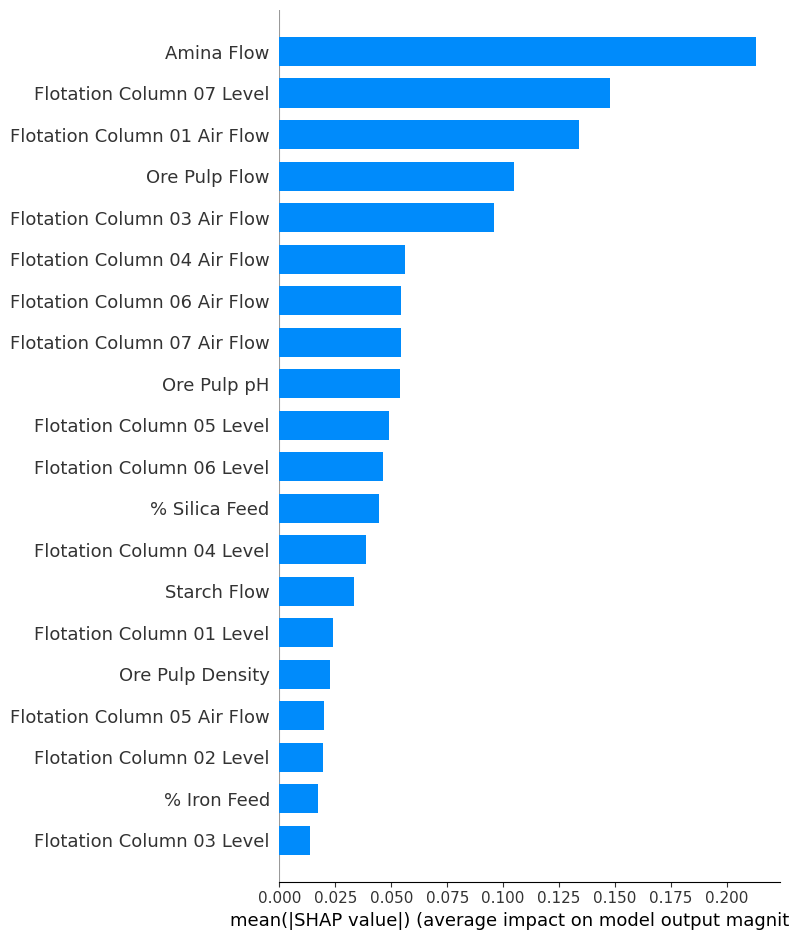



Training MSE: 0.11
Training R^2: 0.91
Testing MSE: 1.25
Testing R^2: 0.05

                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
date                                                                       
2017-03-29 13:00:00        60.18           9.34  2034.926525  322.233975   
2017-03-29 14:00:00        60.18           9.34  1435.425811  474.656322   
2017-03-29 15:00:00        60.18           9.34   618.460387  396.377733   
2017-03-29 16:00:00        59.54           9.56  1367.502858  317.134072   
2017-03-29 17:00:00        59.54           9.56  1729.412710  410.978717   

                     Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
date                                                                
2017-03-29 13:00:00     400.468947     9.700679          1.532017   
2017-03-29 14:00:00     399.157083     9.687788          1.645200   
2017-03-29 15:00:00     398.942522     9.851689          1.559929   
2017-03-29 16:00:00     400.836283     9.9361

In [ ]:

### Random forest with dropped column [% Iron Concentrate]

droplist=['% Iron Concentrate']
try:
    hourly_df = hourly_df.drop(droplist, axis=1)
except KeyError as e:
    print(f"Error: {e}. Columns might not exist in DataFrame.")

#hourly_df = hourly_df.drop(droplist, axis=1)

# Calculate the split index
split_index = int(len(hourly_df) * 0.8)

# Split the DataFrame
train_hourly_df = hourly_df.iloc[:split_index]
test_hourly_df = hourly_df.iloc[split_index:]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the features and target for training set
X_train = train_hourly_df.drop('% Silica Concentrate', axis=1)
y_train = train_hourly_df['% Silica Concentrate']

# Prepare the features and target for testing set
X_test = test_hourly_df.drop('% Silica Concentrate', axis=1)
y_test = test_hourly_df['% Silica Concentrate']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)


# Importance analysis

# Get feature importances
importances = rf_model.feature_importances_

# Convert the importances into a Series with feature names as the index
feature_importances = pd.Series(importances, index=X_test.columns)

# Sort the feature importances in descending order
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,6))
feature_importances_sorted.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

print()
print()

# SHAP analysis

!pip install shap
import shap

# Initialize the explainer with the random forest model and training set

# Initialize the explainer with the model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Plot summary plot of SHAP values for all features across all test instances
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Plot the SHAP values for the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], feature_names=X_test.columns)

# Optional: Mean SHAP value bar plot (average impact on model output magnitude)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

print()
print()

# Make predictions on the training set and calculate metrics
y_train_pred = rf_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training MSE: {train_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}")

# Make predictions on the testing set and calculate metrics
y_test_pred = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Testing MSE: {test_mse:.2f}")
print(f"Testing R^2: {test_r2:.2f}")

print ()
print(hourly_df.head())


# Modeling - Random Forest Regression (part 2):

First attempt to build a random forest regression model wasn't successful. After we dropped [% Iron Concentrate], Testing R^2 dropped to 0.05

Trying to increase the model's performance, I tried other designs of decision trees using Grid Search.

The grid search gave us a set of parameters (below) that increase Testing R^2 from 0.05 to 0.06. So our model still doesn't have any predictive power.

Here is the grid search result:
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
After tuning - Testing MSE: 1.24
After tuning - Testing R^2: 0.06



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Below is the grid search for the best parameters of random forest.
# I will comment out the code snippet for the grid search itself, because it is very computationally intensive.
# after the commented code I put the code for fitting a model with the parameters, found by grid search

"""
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize the base model
rf_base = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV model
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the GridSearchCV model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
best_grid = grid_search.best_estimator_
y_test_pred = best_grid.predict(X_test)

# Calculate metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"After tuning - Testing MSE: {test_mse:.2f}")
print(f"After tuning - Testing R^2: {test_r2:.2f}")
"""

# Below I fit a model with the specific set parameters, found via grid search process
# Now it is commented out - I used it to make sure that if I fit a model with the parameters suggested by the grid search above - I will get the same R^2 and MSE as in the Grid search
# So it is kind of sanity check


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the RandomForestRegressor with the specified parameters
rf_model = RandomForestRegressor(
    n_estimators=200,  # Number of trees in the forest
    bootstrap=True,  # Use bootstrap samples when building trees
    max_depth=30,  # No maximum depth for the trees
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    min_samples_split=5,  # Minimum number of samples required to split an internal node
    random_state=42  # For reproducibility
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)
# Calculate and print training metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training MSE: {train_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}")

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)
# Calculate and print testing metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Testing MSE: {test_mse:.2f}")
print(f"Testing R^2: {test_r2:.2f}")


Training MSE: 0.14
Training R^2: 0.89
Testing MSE: 1.24
Testing R^2: 0.06


# Modeling - LSTM model (part 1):

As we showed earlier, the random forest model shows poor performance on our dataset. Here I decided to try on another model that might show good performance on data serieses - Long-Short Term Memory (LSTM) model. LSTM might be especially promising because it's good at tracking dependencies between Yt and Xt, Xt-1, Xt-2 etc. It makes perfect sense due to the device chain sequences (serial connection of columns) in our flotation plant. Silica that comes to Column 1 in a moment t, comes to the Column 4 in a moment t+1, comes to the Column 7 in a moment t+2, and got measured (% Silica Concentrate) in a moment t+4

The model showed not bad result compared to random forest one: R^2=0.29 vs R^2=0.06


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assuming hourly_df is already loaded and preprocessed - so I need to make sure that I rerun the code snippets that reprocess hourly_df

# Dropping column - commented out because [% Iron Concentrate] is already dropped before
# hourly_df.drop(['% Iron Concentrate'], axis=1, inplace=True)

# Preparing target variable
y = hourly_df['% Silica Concentrate'].values
X = hourly_df.drop('% Silica Concentrate', axis=1).values

# Scaling the features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1)

# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Using last 10 hours to predict the next hour
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

### Building and Training the LSTM Model

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=2)

# Making predictions (Optional)
# To use the predictions, you'll need to inverse transform the scaled predictions
y_pred = model.predict(X_test)


# Evaluate the model
# Calculate MSE value
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing MSE: {test_mse:.4f}")

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)

print(f"Testing R^2: {r2:.2f}")




Epoch 1/30
89/89 - 4s - loss: 0.0860 - val_loss: 0.0502 - 4s/epoch - 50ms/step
Epoch 2/30
89/89 - 1s - loss: 0.0511 - val_loss: 0.0467 - 943ms/epoch - 11ms/step
Epoch 3/30
89/89 - 1s - loss: 0.0489 - val_loss: 0.0525 - 924ms/epoch - 10ms/step
Epoch 4/30
89/89 - 1s - loss: 0.0470 - val_loss: 0.0472 - 869ms/epoch - 10ms/step
Epoch 5/30
89/89 - 1s - loss: 0.0461 - val_loss: 0.0443 - 924ms/epoch - 10ms/step
Epoch 6/30
89/89 - 1s - loss: 0.0458 - val_loss: 0.0438 - 1s/epoch - 11ms/step
Epoch 7/30
89/89 - 1s - loss: 0.0451 - val_loss: 0.0433 - 1s/epoch - 11ms/step
Epoch 8/30
89/89 - 1s - loss: 0.0451 - val_loss: 0.0427 - 956ms/epoch - 11ms/step
Epoch 9/30
89/89 - 1s - loss: 0.0441 - val_loss: 0.0443 - 849ms/epoch - 10ms/step
Epoch 10/30
89/89 - 1s - loss: 0.0443 - val_loss: 0.0422 - 880ms/epoch - 10ms/step
Epoch 11/30
89/89 - 1s - loss: 0.0436 - val_loss: 0.0432 - 859ms/epoch - 10ms/step
Epoch 12/30
89/89 - 1s - loss: 0.0430 - val_loss: 0.0408 - 858ms/epoch - 10ms/step
Epoch 13/30
89/89 - 1s

# Modeling - LSTM model (part 2):

Our LSTM-model with default parameters showed R^2 = 0.29. But as we know, LSTM results are sensitive to their parameters. So, here I would like to select the parameters that might improve performance of the model. By doing manual parameters selection I managed to increase the R^2 from 0.28 for the default parameters to R^2 = 0.52.

Here are the best parameters:
Best MSE: 0.0212
Best R^2: 0.5227
Best params: {'units': 100, 'epochs': 50, 'batch_size': 32, 'lr': 0.001}

We might widen the set of the parameters for manual selection, but it wouldn't drastically improve model performance.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X_train, X_test, y_train, y_test are already defined and properly preprocessed

def build_and_train_model(X_train, y_train, X_test, y_test, params):
    model = Sequential([
        LSTM(params['units'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    # Evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)  # Calculate R^2

    return mse, r2  # Return both metrics

# Define the set of parameters you want to test
param_grid = {
    'units': [50, 100],
    'epochs': [30, 40, 50],
    'batch_size': [16, 32, 48],
    'lr': [0.001, 0.01]
}

# Manual grid search
best_score = np.inf
best_r2 = -np.inf  # Initialize with a very low value
best_params = None

for units in param_grid['units']:
    for epochs in param_grid['epochs']:
        for batch_size in param_grid['batch_size']:
            for lr in param_grid['lr']:
                params = {'units': units, 'epochs': epochs, 'batch_size': batch_size, 'lr': lr}
                mse, r2 = build_and_train_model(X_train, y_train, X_test, y_test, params)  # Get both metrics

                if mse < best_score or (mse == best_score and r2 > best_r2):  # Update logic to consider R^2
                    best_score = mse
                    best_r2 = r2
                    best_params = params

                print(f"Tested params: {params}, MSE: {mse:.4f}, R^2: {r2:.4f}")  # Print both metrics

print(f"Best MSE: {best_score:.4f}")
print(f"Best R^2: {best_r2:.4f}")  # Report the best R^2
print(f"Best params: {best_params}")

25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 30, 'batch_size': 16, 'lr': 0.001}, MSE: 0.0293, R^2: 0.3396
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 30, 'batch_size': 16, 'lr': 0.01}, MSE: 0.0358, R^2: 0.1945
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 30, 'batch_size': 32, 'lr': 0.001}, MSE: 0.0335, R^2: 0.2468
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 30, 'batch_size': 32, 'lr': 0.01}, MSE: 0.0323, R^2: 0.2723
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 30, 'batch_size': 48, 'lr': 0.001}, MSE: 0.0253, R^2: 0.4304
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 30, 'batch_size': 48, 'lr': 0.01}, MSE: 0.0333, R^2: 0.2512
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 40, 'batch_size': 16, 'lr': 0.001}, MSE: 0.0256, R^2: 0.4234
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 40, 'batch_size': 16, 'lr': 0.01}, MSE: 0.0330, R^2: 0.2568
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 40, 'batch_size': 32, 'lr': 0.001}, MSE: 0.0257, R^2: 0.4218
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 40, 'batch_size': 32, 'lr': 0.01}, MSE: 0.0307, R^2: 0.3097
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 40, 'batch_size': 48, 'lr': 0.001}, MSE: 0.0270, R^2: 0.3932
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 40, 'batch_size': 48, 'lr': 0.01}, MSE: 0.0341, R^2: 0.2320
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 50, 'batch_size': 16, 'lr': 0.001}, MSE: 0.0250, R^2: 0.4379
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 50, 'batch_size': 16, 'lr': 0.01}, MSE: 0.0425, R^2: 0.0444
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 50, 'batch_size': 32, 'lr': 0.001}, MSE: 0.0246, R^2: 0.4466
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 50, 'batch_size': 32, 'lr': 0.01}, MSE: 0.0383, R^2: 0.1380
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 50, 'batch_size': 48, 'lr': 0.001}, MSE: 0.0255, R^2: 0.4248
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 50, 'epochs': 50, 'batch_size': 48, 'lr': 0.01}, MSE: 0.0337, R^2: 0.2409
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 30, 'batch_size': 16, 'lr': 0.001}, MSE: 0.0278, R^2: 0.3738
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 30, 'batch_size': 16, 'lr': 0.01}, MSE: 0.0341, R^2: 0.2331
25/25 [==============================] - 1s 3ms/step


Tested params: {'units': 100, 'epochs': 30, 'batch_size': 32, 'lr': 0.001}, MSE: 0.0279, R^2: 0.3727
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 30, 'batch_size': 32, 'lr': 0.01}, MSE: 0.0349, R^2: 0.2148
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 30, 'batch_size': 48, 'lr': 0.001}, MSE: 0.0300, R^2: 0.3245
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 30, 'batch_size': 48, 'lr': 0.01}, MSE: 0.0342, R^2: 0.2292
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 40, 'batch_size': 16, 'lr': 0.001}, MSE: 0.0272, R^2: 0.3874
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 40, 'batch_size': 16, 'lr': 0.01}, MSE: 0.0346, R^2: 0.2220
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 40, 'batch_size': 32, 'lr': 0.001}, MSE: 0.0255, R^2: 0.4253
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 40, 'batch_size': 32, 'lr': 0.01}, MSE: 0.0327, R^2: 0.2628
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 40, 'batch_size': 48, 'lr': 0.001}, MSE: 0.0249, R^2: 0.4405
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 40, 'batch_size': 48, 'lr': 0.01}, MSE: 0.0332, R^2: 0.2517
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 50, 'batch_size': 16, 'lr': 0.001}, MSE: 0.0290, R^2: 0.3475
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 50, 'batch_size': 16, 'lr': 0.01}, MSE: 0.0360, R^2: 0.1887
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 50, 'batch_size': 32, 'lr': 0.001}, MSE: 0.0212, R^2: 0.5227
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 50, 'batch_size': 32, 'lr': 0.01}, MSE: 0.0379, R^2: 0.1469
25/25 [==============================] - 0s 3ms/step


Tested params: {'units': 100, 'epochs': 50, 'batch_size': 48, 'lr': 0.001}, MSE: 0.0249, R^2: 0.4400
25/25 [==============================] - 0s 3ms/step
Tested params: {'units': 100, 'epochs': 50, 'batch_size': 48, 'lr': 0.01}, MSE: 0.0333, R^2: 0.2500
Best MSE: 0.0212
Best R^2: 0.5227
Best params: {'units': 100, 'epochs': 50, 'batch_size': 32, 'lr': 0.001}
